# Classifier Calibraiton  for binary classification

The goal of this notebook is to help you understand classifier calibration, including metrics used to measured classifier calibration and visualize the results.

In [11]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import log_loss, brier_score_loss

In [12]:
# Data Generation
X, y = datasets.make_classification(n_samples=2000, n_features=20, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [13]:
# Models
models = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(kernel='linear', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB()
}



In [14]:
# Training and Predictions
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    predictions[name] = model.predict_proba(X_test)[:, 1]

In [15]:
# Compute ECE using calibration_curve
def compute_ece(y_true, y_prob, n_bins=10):
    true_frequencies, predicted_probabilities = calibration_curve(y_true, y_prob, n_bins=n_bins, strategy='quantile')
    bin_edges = np.linspace(0, 1, n_bins+1)
    bin_width = 1.0 / n_bins
    bin_centers = np.linspace(bin_width/2, 1.0 - bin_width/2, n_bins)
    weights, _ = np.histogram(y_prob, bins=bin_edges, range=(0, 1))
    ece = np.sum(weights * np.abs(predicted_probabilities - bin_centers)) / len(y_prob)
    return ece

In [16]:
# Metrics
results = {
    "Model": [],
    "Log Loss": [],
    "Brier Loss": [],
    "ECE": []
}

In [17]:
for name, preds in predictions.items():
    results["Model"].append(name)
    results["Log Loss"].append(log_loss(y_test, preds))
    results["Brier Loss"].append(brier_score_loss(y_test, preds))
    results["ECE"].append(compute_ece(y_test, preds))

results_df = pd.DataFrame(results)

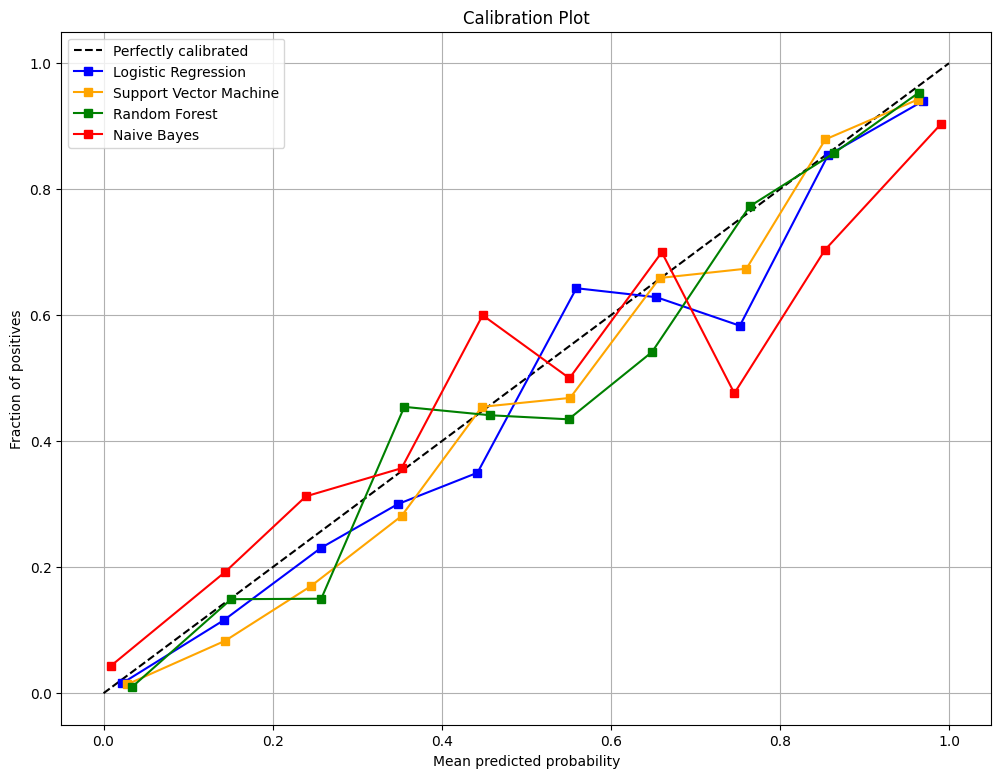

In [26]:
# Calibration Plot
colors = ['blue', 'orange', 'green', 'red']
plt.figure(figsize=(12, 9))
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
for color, (name, preds) in zip(colors, predictions.items()):
    frac, mean = calibration_curve(y_test, preds, n_bins=10)
    plt.plot(mean, frac, "s-", label=name, color=color)
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Plot")
plt.legend()
plt.grid(True)
plt.show()

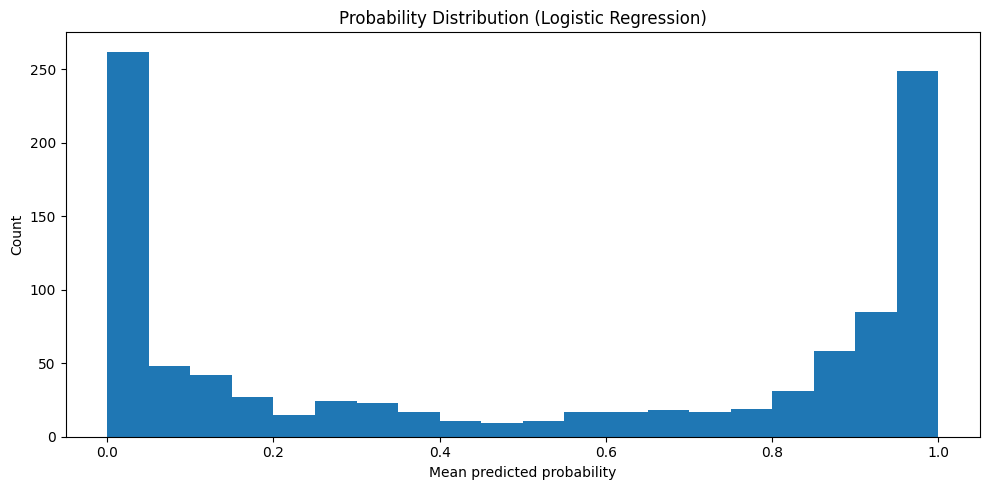

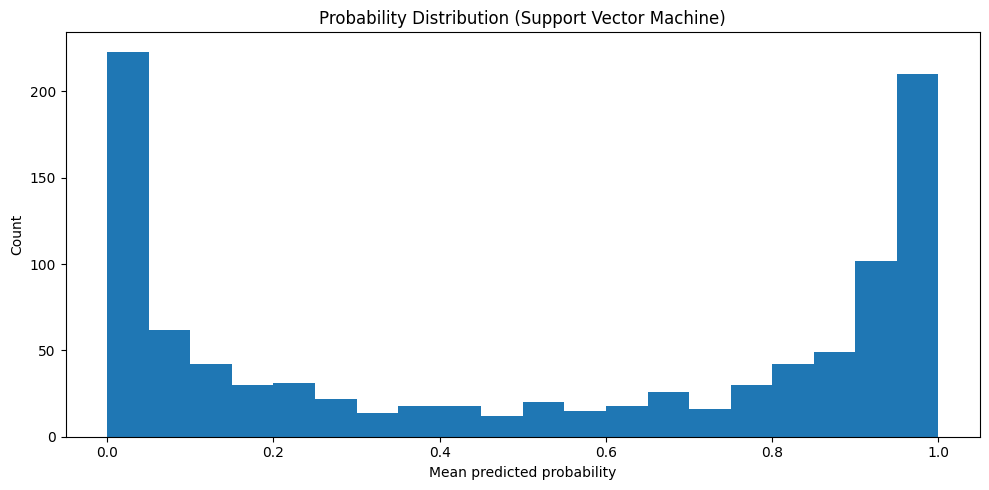

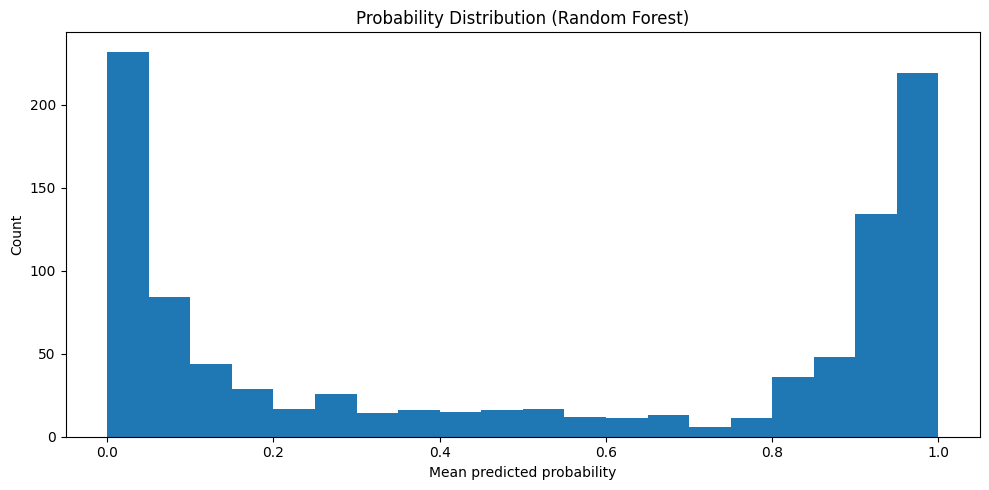

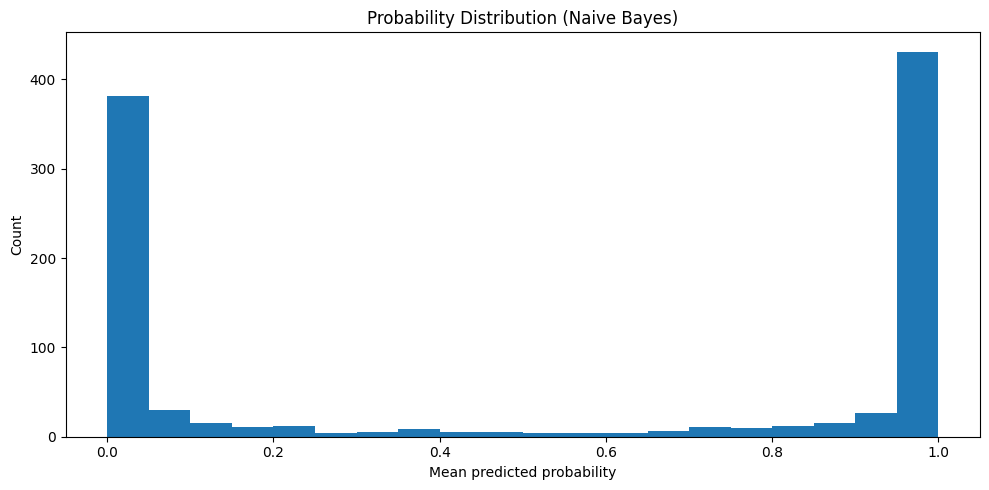

In [24]:
for (name, preds) in predictions.items():
    # Plot Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(preds, range=(0, 1), bins=20, label=name)
    plt.title(f"Probability Distribution ({name})")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

In [27]:
# Display the results table
results_df

,Model,Log Loss,Brier Loss,ECE
0,Logistic Regression,0.292348,0.086274,0.088519
1,Support Vector Machine,0.291903,0.086721,0.085410
2,Random Forest,0.324370,0.076712,0.078765
3,Naive Bayes,0.388189,0.089296,0.072434


Adapted from: https://github.com/PacktPublishing/Practical-Guide-to-Applied-Conformal-Prediction/blob/main/Chapter_6_classifier_calibration.ipynb

Author: Valeriy Manokhin